In [1]:
# Import all the things we need ---
# by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling1D, ZeroPadding2D, Conv2D, Conv1D
from keras.utils import plot_model
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras
import tensorflow as tf
import seaborn as sn

from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Function for plotting confusion matrix
def plot_confusion_matrix(cm, filename, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):   
    with PdfPages(filename) as pdf:
        # As many times as you like, create a figure fig and save it:
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        pdf.savefig(fig, dpi = 1000, bbox_inches='tight')
        
        
def get_snrs(data_path):
    
    Xd = cPickle.load(open(data_path,'rb'), encoding="latin1")
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    
    return snrs

Using TensorFlow backend.


# Conv2D model

In [4]:
def get_conv2d_accuracy(conv2d_path, conv2d_weight_path):

    #==================PREPARE DATA=====================
    
    print("Preparing the data ...")
    # Prepare the training data
    # You will need to seperately download or generate this file
    Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding="latin1")
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
    X = np.vstack(X)

    # Partition the data into training, validation, and test sets while keeping SNR and Mod labels handy for each
    np.random.seed(2016)

    #Number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * 0.6)
    n_val = int(n_examples * 0.2)

    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    val_idx = np.random.choice(list(set(range(0,n_examples))-set(train_idx)), size=n_val, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx)-set(val_idx))

    X_train = X[train_idx]
    X_val = X[val_idx]
    X_test =  X[test_idx]

    #Add empty dimension at the end for CONV input layer
    X_train = X_train.reshape(X_train.shape + (1,))
    X_val = X_val.reshape(X_val.shape + (1,))
    X_test = X_test.reshape(X_test.shape + (1,))


    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy)+1])
        yy1[np.arange(len(yy)),yy] = 1
        return yy1

    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))


    #Print out the shapes for different datasets
    print ("Total number of samples: ", X.shape[0])
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of validation examples = " + str(X_val.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))

    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))

    print ("X_val shape: " + str(X_val.shape))
    print ("Y_val shape: " + str(Y_val.shape))

    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))

    #Input shape and number of classes
    in_shape = list(X_train.shape[1:])
    classes = mods
    num_classes = len(classes)

    print("X_train shape: ", X_train.shape)
    print("Number of classes: ", num_classes)
    
    
    
    #Load the model
    print("Loading Conv2D model")
    with open(conv2d_path, 'r') as f:
        model = tf.keras.models.model_from_json(f.read())

    #Load weights into new model
    model.load_weights(conv2d_weight_path,"r")
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    
    
    # Plot confusion matrix
    print("Calculating accuracies for different SNRs")
    acc = {}
    for snr in snrs:

        # extract classes @ SNR
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

        # estimate classes
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        #Plot confusion matrix at snr = 18
        #if snr == 18:
            #plt.figure()
            #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv2D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)
        
    return acc

In [5]:
#Set accuracy to some variable for easy comparison with other models
Conv2D_full_acc = get_conv2d_accuracy("./CNN/model/Conv2D-full.json", "./CNN/model/Conv2D-full.h5")

Preparing the data ...
Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 2, 128, 1)
Y_train shape: (132000, 11)
X_val shape: (44000, 2, 128, 1)
Y_val shape: (44000, 11)
X_test shape: (44000, 2, 128, 1)
Y_test shape: (44000, 11)
X_train shape:  (132000, 2, 128, 1)
Number of classes:  11
Loading Conv2D model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 121, 64)        1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 121, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 90, 32)         65568     
_________________________________________________________________
dropout_2 (Dropout)         

# Conv1D models

In [8]:
def get_conv1d_accuracy(json_dir, h5_dir):
    """
    Calculate the conv1d accuracy in different SNR.
    """
    
    print("Preparing the data ...")
    
    #==================PREPARE DATA=====================

    # Prepare the training data
    # You will need to seperately download or generate this file
    Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding="latin1")
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
    X = np.vstack(X)

    # Partition the data into training, validation, and test sets while keeping SNR and Mod labels handy for each
    np.random.seed(2016)

    #Number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * 0.6)
    n_val = int(n_examples * 0.2)

    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    val_idx = np.random.choice(list(set(range(0,n_examples))-set(train_idx)), size=n_val, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx)-set(val_idx))

    X_train = X[train_idx]
    X_val = X[val_idx]
    X_test =  X[test_idx]

    def to_onehot(yy):
        yy1 = np.zeros([len(yy), max(yy)+1])
        yy1[np.arange(len(yy)),yy] = 1
        return yy1

    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    #Flip the last two dimensions
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2],X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0],X_val.shape[2],X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

    #Print out the shapes for different datasets
    print ("Total number of samples: ", X.shape[0])
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of validation examples = " + str(X_val.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))

    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))

    print ("X_val shape: " + str(X_val.shape))
    print ("Y_val shape: " + str(Y_val.shape))

    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))

    #Input shape and number of classes
    in_shape = list(X_train.shape[1:])
    classes = mods
    num_classes = len(classes)

    print("Number of classes: ", num_classes)
    
    print("Loading the model ...")
    
    # Load the model
    with open(json_dir, 'r') as f:
        model = tf.keras.models.model_from_json(f.read())
    #load weights into new model
    model.load_weights(h5_dir,"r")
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    
    # Plot confusion matrix
    print("Calculating accuracy ...")
    acc = {}
    for snr in snrs:

        # extract classes @ SNR
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

        # estimate classes
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        #Plot confusion matrix at snr = 18
        #if snr == 18:
            #plt.figure()
            #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)
        
    return acc

In [6]:
!ls CNN/model

Conv1D-0.85.h5   Conv1D-0.95.h5   Conv1D-full.h5   Conv2D-full.h5
Conv1D-0.85.json Conv1D-0.95.json Conv1D-full.json Conv2D-full.json


In [10]:
Conv1D_full_acc = get_conv1d_accuracy("./CNN/model/Conv1D-full.json", "./CNN/model/Conv1D-full.h5")

Preparing the data ...
Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 128, 2)
Y_train shape: (132000, 11)
X_val shape: (44000, 128, 2)
Y_val shape: (44000, 11)
X_test shape: (44000, 128, 2)
Y_test shape: (44000, 11)
Number of classes:  11
Loading the model ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 128)          896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 64)            24640     
______

In [11]:
Conv1D_85_acc = get_conv1d_accuracy("./CNN/model/Conv1D-0.85.json", "./CNN/model/Conv1D-0.85.h5")

Preparing the data ...
Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 128, 2)
Y_train shape: (132000, 11)
X_val shape: (44000, 128, 2)
Y_val shape: (44000, 11)
X_test shape: (44000, 128, 2)
Y_test shape: (44000, 11)
Number of classes:  11
Loading the model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 126, 128)          896       
_________________________________________________________________
conv2 (Conv1D)               (None, 124, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 128)           0         
_________________________________________________________________
conv3 (Conv1D)               (None, 60, 64)            24640     
________

In [12]:
Conv1D_95_acc = get_conv1d_accuracy("./CNN/model/Conv1D-0.95.json", "./CNN/model/Conv1D-0.95.h5")

Preparing the data ...
Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 128, 2)
Y_train shape: (132000, 11)
X_val shape: (44000, 128, 2)
Y_val shape: (44000, 11)
X_test shape: (44000, 128, 2)
Y_test shape: (44000, 11)
Number of classes:  11
Loading the model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 126, 128)          896       
_________________________________________________________________
conv2 (Conv1D)               (None, 124, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 128)           0         
_________________________________________________________________
conv3 (Conv1D)               (None, 60, 64)            24640     
________

Text(0.5,1,'Classification Accuracy on RadioML 2016.10 Alpha')

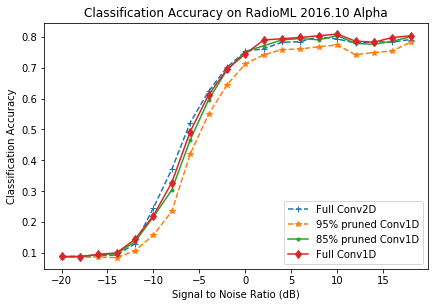

In [13]:
snrs = get_snrs("RML2016.10a_dict.pkl")

# As many times as you like, create a figure fig and save it:
fig = plt.figure()

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: Conv2D_full_acc[x], snrs)),"+--", label = "Full Conv2D")
plt.plot(snrs, list(map(lambda x: Conv1D_95_acc[x], snrs)), "*--", label = "95% pruned Conv1D")
plt.plot(snrs, list(map(lambda x: Conv1D_85_acc[x], snrs)), ".-",label = "85% pruned Conv1D")
plt.plot(snrs, list(map(lambda x: Conv1D_full_acc[x], snrs)), "d-", label = "Full Conv1D")

plt.legend(loc='lower right')
plt.tight_layout()

plt.xlabel("Signal to Noise Ratio (dB)", )
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on RadioML 2016.10 Alpha")
#plt.savefig(fig, dpi = 1000, bbox_inches='tight')

# Size and performance comparisons 

In [14]:
import tempfile
import zipfile
import os

keras_file = "./CNN/model/Conv1D-full.h5"

pruned_keras_file_85 = "./CNN/model/Conv1D-0.85.h5"

pruned_keras_file_95 = "./CNN/model/Conv1D-0.95.h5"

_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(keras_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(keras_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file_85)
print("Size of the pruned 85 percent model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file_85) / float(2**20)))
print("Size of the pruned 85 percent model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

_, zip3 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file_95)
print("Size of the pruned 95 percent model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file_95) / float(2**20)))
print("Size of the pruned 95 percent model after compression: %.2f Mb" % 
      (os.path.getsize(zip3) / float(2**20)))

Size of the unpruned model before compression: 2.45 Mb
Size of the unpruned model after compression: 2.05 Mb
Size of the pruned 85 percent model before compression: 0.83 Mb
Size of the pruned 85 percent model after compression: 0.20 Mb
Size of the pruned 95 percent model before compression: 0.83 Mb
Size of the pruned 95 percent model after compression: 0.11 Mb
